In [1]:
##Opening Data And saving

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

!ls '/content/drive/My Drive/DeepLearningLabs/Lab5/data/'
myDrive = '/content/drive/My Drive/DeepLearningLabs/Lab5/data/'
myRoot = '/content/drive/My Drive/DeepLearningLabs/Lab5/'
%run /content/drive/My\ Drive/DeepLearningLabs/Lab5/Datasets.py

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
AEMnist  CK  CVAECK  GANCK  GANMnist  mnist  MNIST_DAE	samples


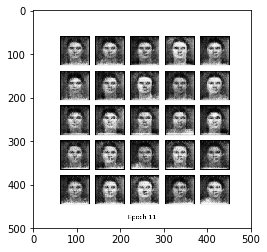

In [2]:
#Example result 
from PIL import Image
import matplotlib.pyplot as plt

#Example results 
epoch = 1
resName = myDrive+'GANCK/fr/CK_DCGAN_11.png'
plt.imshow(Image.open(resName))

In [0]:
from PIL import Image

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Training parameters
data_root = myDrive + '/CK'
workers = 2
batch_size = 32
image_size = 64

num_channels = 3 #rgb
z_size = 100 # Size of the latent vector

c_dim = 8

num_epochs = 5
lr = 0.0002
beta1 = 0.5 #for Adam optimizers

device = 'cuda' if torch.cuda.is_available else 'cpu'

fixed_noise = torch.randn(batch_size, z_size, 1, 1).to(device)
real_label = torch.ones(batch_size).to(device)
fake_label = torch.zeros(batch_size).to(device)


transform=transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)), # bring images to (-1,1)
        ])

print(device)

cuda


In [0]:
class Generator(nn.Module):

    def __init__(self, conv_dim=64, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2     
            
        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
    
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        c = c.unsqueeze(2).unsqueeze(3)
        c = c.expand(c.size(0), c.size(1), x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, image_size=64, conv_dim=64, repeat_num=6):
        super(Discriminator, self).__init__()        

        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Sequential(
            nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Sigmoid()
        )
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        
        return out_src.squeeze(), out_cls.squeeze()

In [0]:
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
            if hasattr(m.bias, 'data'):
                m.bias.data.fill_(0)
        elif classname.find('BatchNorm2d') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [0]:
class CKDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        self.transform = transform
        self.imgs_path = []
        self.labels = []
        
        # Get img paths
        for root, dirs, files in os.walk(root):
            for f in files:
                self.imgs_path.append(os.path.join(root, f))
                self.labels.append(int(os.path.join(root, f).split('/')[-2]))
        print(len(self.imgs_path), "images")

    def __getitem__(self, index):
        img = self.imgs_path[index]
        img = Image.open(img).convert('RGB')
        img = self.transform(img)
        
        label = self.labels[index]
        
        return img, label

    def __len__(self):
        return len(self.imgs_path)


In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.01)
  )
  (conv1): Sequential(
    (0): Conv2d(2048, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (conv2): Conv2d(2048, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
)

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()
criterion_mse = nn.MSELoss()

fixed_noise = torch.randn(batch_size, z_size, 1, 1).to(device)

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
ck_dataset = CKDataset(data_root, transform)
dataloader = torch.utils.data.DataLoader(ck_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last = True)


6849 images


In [13]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # Train Discriminator
        optimizerD.zero_grad()
        
        real_image = data[0]
        real_labels = torch.zeros(batch_size, c_dim)
        
        real_labels[:,data[1]-1] = 1

        real_image, real_labels = real_image.to(device), real_labels.to(device)
        d_real_output, d_real_labels = discriminator(real_image)
        loss_d_real = criterion(d_real_output.view(-1), real_label.view(-1))
        loss_d_real_labels = criterion_mse(d_real_labels, real_labels)
        
        rand_perm = torch.randperm(batch_size)
        target_labels = real_labels[rand_perm]
        
        fake_image = generator(real_image, target_labels)
        
        d_fake_output, _ = discriminator(fake_image.detach())
        loss_d_fake = criterion(d_fake_output.view(-1), fake_label.view(-1))        

        d_total_loss = loss_d_real + loss_d_fake + loss_d_real_labels
        d_total_loss.backward()
        optimizerD.step()
        
        
        if i % 4 == 0:
          # Train the generator
          optimizerG.zero_grad()

          g_d_fake_output, g_fake_labels = discriminator(fake_image)
          g_loss = criterion(g_d_fake_output.view(-1), real_label.view(-1))
          g_loss_labels = criterion_mse(g_fake_labels, target_labels)


          g_total_loss = g_loss + g_loss_labels
          g_total_loss.backward()
          optimizerG.step()

          # Output training stats
          if i % 5 == 0:
              print(f'{epoch}/{num_epochs} [{i}/{len(dataloader)}]'
                     f'Loss D: {d_total_loss.item()}, Loss G {g_total_loss.item()}')

          # Save Losses for plotting later
          G_losses.append(g_total_loss.item())
          D_losses.append(d_total_loss.item())

          # Check how the generator is doing by saving G's output on fixed_noise
          if i % 10 == 0:
              img_list.append(vutils.make_grid(fake_image, padding=2, normalize=True))


Starting Training Loop...
0/5 [0/214]Loss D: 2.1346538066864014, Loss G 1.3803246021270752
0/5 [20/214]Loss D: 0.24006307125091553, Loss G 4.009833812713623
0/5 [40/214]Loss D: 0.6238811016082764, Loss G 2.244541645050049
0/5 [60/214]Loss D: 0.28391891717910767, Loss G 3.7339580059051514
0/5 [80/214]Loss D: 0.24518050253391266, Loss G 2.780686378479004
0/5 [100/214]Loss D: 0.3288038969039917, Loss G 3.3776450157165527
0/5 [120/214]Loss D: 0.816214919090271, Loss G 1.8267931938171387
0/5 [140/214]Loss D: 0.5172767043113708, Loss G 2.0277132987976074
0/5 [160/214]Loss D: 0.7619825005531311, Loss G 1.6732522249221802
0/5 [180/214]Loss D: 0.38573744893074036, Loss G 2.586646318435669
0/5 [200/214]Loss D: 0.752959132194519, Loss G 2.298827648162842
1/5 [0/214]Loss D: 0.5066910982131958, Loss G 2.480178117752075
1/5 [20/214]Loss D: 0.31482264399528503, Loss G 3.1897401809692383
1/5 [40/214]Loss D: 0.25555694103240967, Loss G 2.864182233810425
1/5 [60/214]Loss D: 0.6551885008811951, Loss G 2.

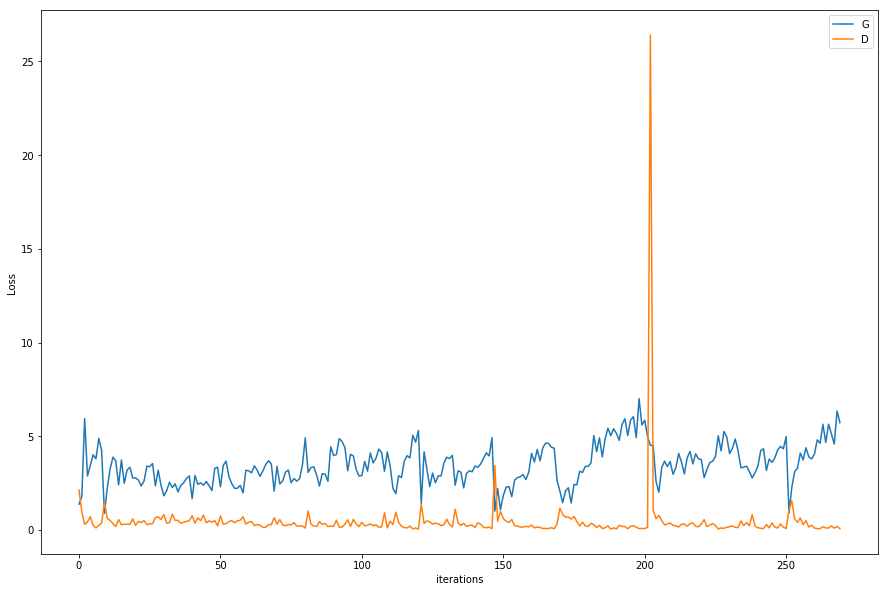

In [14]:
plt.figure(figsize=(15,10))
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

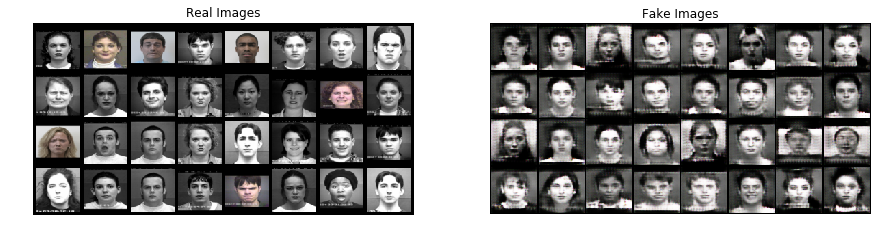

In [18]:
# Grab a batch of real images from the dataloader
real_image = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_image[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1].cpu().detach(),(1,2,0)))
plt.show()